In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [5]:
class Quantize:
    def __init__(self, data, name, present):
        self.data = data
        self.name = name
        self.open_price = present['Open']
        self.df = data#.set_index('Date').dropna()
        self.oc = self.df['Close']/self.df['Open']
        self.rate = np.array(self.oc)
        self.dif = np.max(self.rate) - np.min(self.rate)
        self.std = np.std(self.rate)
        self.intv = int(round((self.dif * 50)/(3*self.std), 0))
        self.x = np.linspace(np.min(self.rate), np.max(self.rate), self.intv)
        self.y = np.zeros(self.intv)
        for r in self.rate:
            j = 0
            while j < len(self.x)-1:
                #if self.x[len(self.x)-1] <= r:
                    #self.y[len(self.x)-1] += 1/(len(self.rate))
                if r >= self.x[j] and r < self.x[j+1]:
                    self.y[j] += 1/(len(self.rate))
                j += 1
            
  ## Drawing a wave function
    def wave_eq(self):
        plt.plot(self.x, self.y, label = self.name)
        plt.title('wave equation', pad = 10)
        plt.legend(loc='upper right') 
        plt.show()

  ## Calculating a lambda to solve the schrodinger equation
    def calculate_lambda(self):
        self.base = list(self.y).index(np.max(self.y))
        self.gs = self.x[self.base]
        self.uf = self.x[self.base + 1]
        self.df = self.x[self.base - 1]
        self.wave_gs = self.y[self.base]
        self.wave_uf = self.y[self.base + 1]
        self.wave_df = self.y[self.base - 1]
        self.numerator = (np.power(self.df, 2) * self.wave_df) - (np.power(self.uf, 2) * self.wave_uf)
        self.denominator = (np.power(self.uf, 4) * self.wave_uf) - (np.power(self.df, 4) * self.wave_df)
        self.lam = np.abs(self.numerator / self.denominator)

  ## Solving the schrodinger equation and Calculating K, QPEL, QPR, NQPR, QPL)
    def solve_se(self):
        from sympy import Symbol, solve
        self.k_n = np.zeros(21)
        self.e_n = np.zeros(21)
        self.qpr_n = np.zeros(21)
        self.nqpr_n = np.zeros(21)
        self.qpl_zero = np.zeros(1)
        self.qpl_positive = np.zeros(20)
        self.qpl_negative = np.zeros(20)
    
        #K0(n)
        for x in range(21):
            numer = (1.1924 + 33.2383 * x + 56.2169 * np.power(x, 2))
            denom = (1 + 43.6196 * x)
            self.k_n[x] = np.cbrt(numer/denom)

        #E(n)
        for y in range(21):
            e = Symbol('x')
            base = e / (2*y + 1)
            third_term = np.power(self.k_n[y], 3) * self.lam
            equation = (base ** 3) - base - third_term
            #print(solve(equation))
            self.e_n[y] = solve(equation)[0]

        #QPR(n)
        for z in range(21):
            self.qpr_n[z] = self.e_n[z] / self.e_n[0]

        #NQPR(n)
        for a in range(21):
            self.nqpr_n[a] = 1 + (0.21 * self.std * self.qpr_n[a])

        #QPL(0)
        self.qpl_zero[0] = self.open_price * self.nqpr_n[0]

        #QPL(+n), QPL(-n)
        for p in range(20):
            self.qpl_positive[p] = self.open_price * self.nqpr_n[p+1]
            self.qpl_negative[p] = self.open_price / self.nqpr_n[p+1]

        self.qpl_positive = (np.insert(self.qpl_positive, 0, self.qpl_zero[0], axis=0))
        self.qpl_negative = (np.insert(self.qpl_negative, 0, self.qpl_zero[0], axis=0))
  
  ## Setting a dataframe for the data        
    def set_dataframe(self):
        Energy = np.arange(21)
        self.temp = np.array([self.e_n, self.qpr_n, self.nqpr_n, 
                          self.qpl_positive, self.qpl_negative])
        self.result_df = pd.DataFrame(np.transpose(self.temp), columns=['QPE', 'QPR', 'NQPR', 'QPL_Positive', 'QPL_Negative'])
        #print(self.result_df)
    
    def get_20_qpl(self):
        self.qpl_20 = np.append(self.qpl_negative[::-1][1:11],self.qpl_positive[1:11])
        return self.qpl_20



In [6]:
# ticker, n = until n days ago
def give_me_df_til_yesterday(ticker, n):
    stock = yf.Ticker(ticker)
    df = stock.history(period='3000d')
    df = df.iloc[:-n,:4]
    return df

# ticker, n-1 days ago 
def give_me_dt_today(ticker, n):
    stock = yf.Ticker(ticker)
    df = stock.history(period='3000d')
    df = df.iloc[-n, :4]
    return df

# ticker, to be ready for making 24 inputs
def give_me_df_ndays_qpl(ticker, n):
    stock = yf.Ticker(ticker)
    df = stock.history(period=f'{n}d')
    df = df.iloc[:, :4]
    for i in range(20):
        df[f'QPL{i+1}'] = df['Open'] * 0
    return df


In [261]:
''' 애플꺼 200개 뽑기...(24 inputs) 근데, 200은 퍼포먼스가 좋지 않고 (에러가 10퍼센트 정도 였습니다.) 
Schrodinger equation 푸는 도중 400개 이상에서 오류가 나서 포기했습니다. 노트북 문제인지, 방정식 푸는 과정이 꽤나 길어서 그런지 
생각보다 데이터셋 만드는 데 드는 시간이 상당했습니다.
'''

i = 1
data = give_me_df_ndays_qpl('AAPL', 200)
while i <= 200:
    aapl_y = give_me_df_til_yesterday('AAPL', i)
    aapl_t = give_me_dt_today('AAPL', i)
    ap = Quantize(aapl_y, 'Apple', aapl_t)
    #ap.wave_eq()
    ap.calculate_lambda()
    ap.solve_se()
    ap.set_dataframe()
    clo_qpl = ap.get_20_qpl()
    j = 0
    while j < 20:
        data.iloc[200-i,j+4] = clo_qpl[j]
        j = j + 1   
    i += 1
    if i % 10 == 0:
        print(i)
print(data)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
                  Open        High         Low       Close       QPL1  \
Date                                                                    
2020-03-10   68.854808   71.165369   66.924364   70.892075  48.127002   
2020-03-11   68.916918   69.868469   67.542994   68.429955  48.169975   
2020-03-12   63.587710   67.080884   61.615034   61.672176  44.445704   
2020-03-13   65.811319   69.545488   62.844849   69.061012  45.999493   
2020-03-16   60.111926   64.367833   59.627454   60.176525  42.013646   
...                ...         ...         ...         ...        ...   
2020-12-15  124.339996  127.900002  124.129997  127.879997  87.289191   
2020-12-16  127.410004  128.369995  126.559998  127.809998  89.443755   
2020-12-17  128.899994  129.580002  128.039993  128.699997  90.491062   
2020-12-18  128.960007  129.100006  126.120003  126.660004  90.543768   
2020-12-21  125.019997  127.279999  123.448997  126.8

In [7]:
### S&P 500 ETF, 1000개 기준으로 했을 때, 애플보다는 훨씬 좋은 퍼포먼스를 보여줬습니다.

i = 1
data_spy = give_me_df_ndays_qpl('SPY', 2000)
while i <= 2000:
    spy_y = give_me_df_til_yesterday('SPY', i)
    spy_t = give_me_dt_today('SPY', i)
    spy = Quantize(spy_y, 'SPY', spy_t)
    #ap.wave_eq()
    spy.calculate_lambda()
    spy.solve_se()
    spy.set_dataframe()
    spy_clo_qpl = spy.get_20_qpl()
    j = 0
    while j < 20:
        data_spy.iloc[2000-i,j+4] = spy_clo_qpl[j]
        j = j + 1   
    i += 1
    if i % 10 == 0:
        print(i)
print(data_spy)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
                  Open        High         Low       Close        QPL1  \
Date                              

In [8]:
### BIT-USD, 가장 좋은 퍼포먼스를 보여줬습니다. (500개와 1000개 간에 유의미한 차이가 있었습니다.)

i_btc = 1
data_btc_2 = give_me_df_ndays_qpl('BTC-USD', 2000)
print(data_btc_2)
while i_btc <= 2000:
    btcusd_y = give_me_df_til_yesterday('BTC-USD', i_btc)
    btcusd_t = give_me_dt_today('BTC-USD', i_btc)
    btcusd = Quantize(btcusd_y, 'BTC-USD', btcusd_t)
    #ap.wave_eq()
    btcusd.calculate_lambda()
    btcusd.solve_se()
    btcusd.set_dataframe()
    bu_clo_qpl = btcusd.get_20_qpl()
    j_btc = 0
    while j_btc < 20:
        data_btc_2.iloc[2000-i_btc,j_btc+4] = bu_clo_qpl[j_btc]
        j_btc = j_btc + 1   
    i_btc += 1
    if i_btc % 10 == 0:
        print(i_btc)
print(data_btc_2)

                    Open          High           Low         Close  QPL1  \
Date                                                                       
2015-07-05    260.804993    274.506012    258.700989    271.912994   0.0   
2015-07-06    271.108002    277.421997    267.600006    269.029999   0.0   
2015-07-07    269.963013    271.341003    264.832001    266.207001   0.0   
2015-07-08    265.981995    272.971008    264.385986    270.785004   0.0   
2015-07-09    270.826996    272.334991    267.085999    269.227997   0.0   
...                  ...           ...           ...           ...   ...   
2020-12-20  23861.765625  24209.660156  23147.710938  23477.294922   0.0   
2020-12-21  23474.455078  24059.982422  22159.367188  22803.082031   0.0   
2020-12-22  22794.039062  23789.902344  22430.605469  23783.029297   0.0   
2020-12-23  23781.974609  24024.490234  22802.646484  23241.345703   0.0   
2020-12-24  22832.791016  23212.548828  22820.304688  22845.529297   0.0   

           

In [11]:
### Tesla

i_tsla = 1
data_tsla = give_me_df_ndays_qpl('TSLA', 2000)
print(data_tsla)
while i_tsla <= 2000:
    tsla_y = give_me_df_til_yesterday('TSLA', i_tsla)
    tsla_t = give_me_dt_today('TSLA', i_tsla)
    tsla = Quantize(tsla_y, 'TSLA', tsla_t)
    #ap.wave_eq()
    tsla.calculate_lambda()
    tsla.solve_se()
    tsla.set_dataframe()
    ts_clo_qpl = tsla.get_20_qpl()
    j_tsla = 0
    while j_tsla < 20:
        data_tsla.iloc[2000-i_tsla,j_tsla+4] = ts_clo_qpl[j_tsla]
        j_tsla = j_tsla + 1   
    i_tsla += 1
    if i_tsla % 10 == 0:
        print(i_tsla)
print(data_tsla)

                  Open        High         Low       Close  QPL1  QPL2  QPL3  \
Date                                                                           
2013-01-16    6.770000    6.846000    6.746000    6.820000   0.0   0.0   0.0   
2013-01-17    6.832000    6.970000    6.784000    6.876000   0.0   0.0   0.0   
2013-01-18    6.948000    6.956000    6.764000    6.904000   0.0   0.0   0.0   
2013-01-22    6.912000    7.110000    6.852000    7.038000   0.0   0.0   0.0   
2013-01-23    7.004000    7.248000    6.992000    7.200000   0.0   0.0   0.0   
...                ...         ...         ...         ...   ...   ...   ...   
2020-12-17  628.190002  658.820007  619.500000  655.900024   0.0   0.0   0.0   
2020-12-18  668.900024  695.000000  628.539978  695.000000   0.0   0.0   0.0   
2020-12-21  666.239990  668.500000  646.070007  649.859985   0.0   0.0   0.0   
2020-12-22  648.000000  649.880005  614.229980  640.340027   0.0   0.0   0.0   
2020-12-23  632.200012  651.500000  622.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
RMSE: 0.030928082764148712


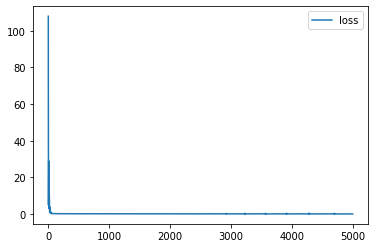

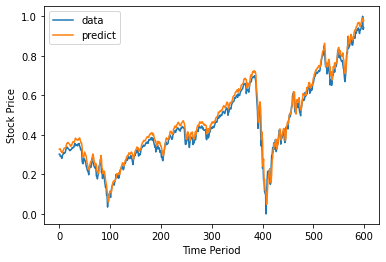

In [9]:
# S&P 500 ETF High

tf.set_random_seed(0) 
tf.reset_default_graph()

import matplotlib.pyplot as plt


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 30
data_dim = 24
hidden_dim = 54
output_dim = 1
learning_rate = 0.0005
iterations = 5000


# train/test split

#부득이하게 위에서 PD_Dataframe으로 가져와서 Numpy로 바꿔주는 과정인데, 한번 바꿔주고 Sensitivity analysis 진행할 때는 필요가 없어서 
# #처리 해놨습니다.
data_spy = data_spy.to_numpy()
train_size = int(len(data_spy) * 0.7)
train_set = data_spy[0:train_size]
test_set = data_spy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)
        #print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions    
    plt.plot(loss_temp, label = 'loss')
    plt.legend()
    plt.show()

    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.030502885580062866


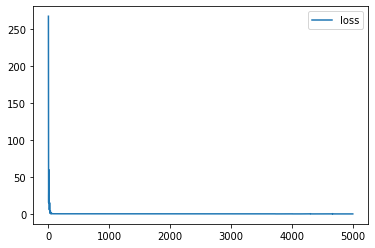

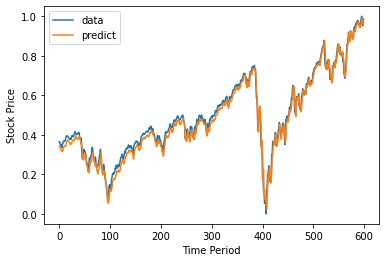

In [17]:
# S&P 500 ETF Low

tf.set_random_seed(0) 
tf.reset_default_graph()

import matplotlib.pyplot as plt


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 30
data_dim = 24
hidden_dim = 54
output_dim = 1
learning_rate = 0.0005
iterations = 5000


# train/test split

#부득이하게 위에서 PD_Dataframe으로 가져와서 Numpy로 바꿔주는 과정인데, 한번 바꿔주고 Sensitivity analysis 진행할 때는 필요가 없어서 
# #처리 해놨습니다.
# data_spy = data_spy.to_numpy()
train_size = int(len(data_spy) * 0.7)
train_set = data_spy[0:train_size]
test_set = data_spy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [2]]  # Next low price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)
        #print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions    
    plt.plot(loss_temp, label = 'loss')
    plt.legend()
    plt.show()

    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.025720136240124702


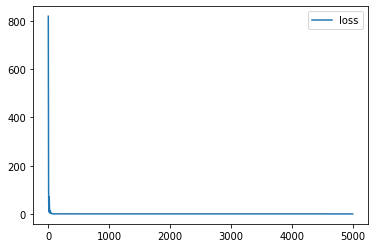

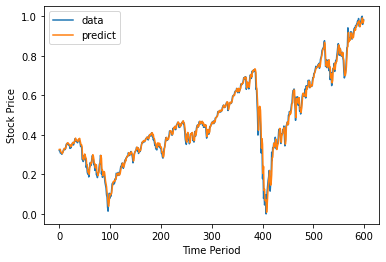

In [18]:
# S&P 500 ETF Open

tf.set_random_seed(0) 
tf.reset_default_graph()

import matplotlib.pyplot as plt


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 30
data_dim = 24
hidden_dim = 54
output_dim = 1
learning_rate = 0.0005
iterations = 5000


# train/test split

#부득이하게 위에서 PD_Dataframe으로 가져와서 Numpy로 바꿔주는 과정인데, 한번 바꿔주고 Sensitivity analysis 진행할 때는 필요가 없어서 
# #처리 해놨습니다.
#data_spy = data_spy.to_numpy()
train_size = int(len(data_spy) * 0.7)
train_set = data_spy[0:train_size]
test_set = data_spy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [0]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)
        #print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions    
    plt.plot(loss_temp, label = 'loss')
    plt.legend()
    plt.show()

    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.017233556136488914


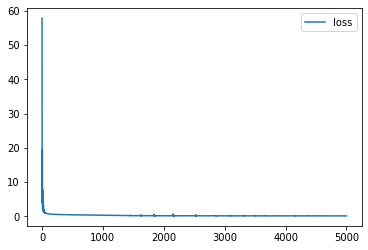

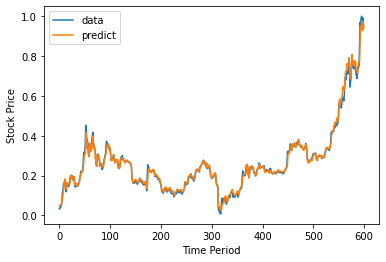

In [10]:
# BTC-USD High

tf.reset_default_graph()
tf.set_random_seed(0) 

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 20
data_dim = 24
hidden_dim = 34
output_dim = 1
learning_rate = 0.001
iterations = 5000

#data_btc = data_btc.to_numpy()

# train/test split
data_btc_2 = data_btc_2.to_numpy()
train_size = int(len(data_btc_2) * 0.7)
train_set = data_btc_2[0:train_size]
test_set = data_btc_2[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [1]]  # Next close price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)

        #print("[step: {}] loss: {}".format(i, step_loss))
    
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    plt.plot(loss_temp, label='loss')
    plt.legend()
    plt.show()

    # Plot predictions
    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.03150768578052521


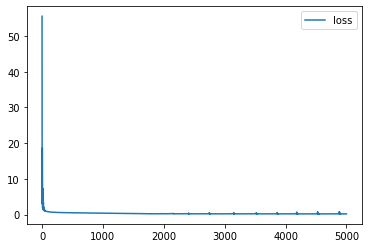

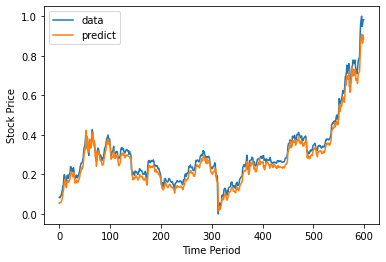

In [13]:
# BTC-USD (Low)

tf.reset_default_graph()
tf.set_random_seed(0) 

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 20
data_dim = 24
hidden_dim = 34
output_dim = 1
learning_rate = 0.001
iterations = 5000

#data_btc = data_btc.to_numpy()

# train/test split
#data_btc_2 = data_btc_2.to_numpy()
train_size = int(len(data_btc_2) * 0.7)
train_set = data_btc_2[0:train_size]
test_set = data_btc_2[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [2]]  # Next low price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)

        #print("[step: {}] loss: {}".format(i, step_loss))
    
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    plt.plot(loss_temp, label='loss')
    plt.legend()
    plt.show()

    # Plot predictions
    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.008456256240606308


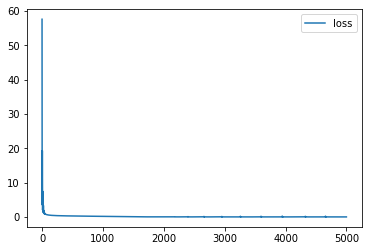

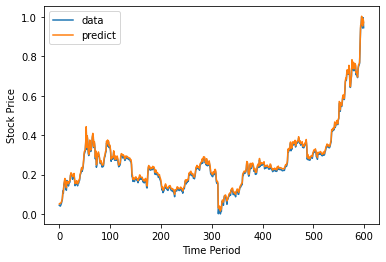

In [14]:
# BTC-USD Open

tf.reset_default_graph()
tf.set_random_seed(0) 

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 20
data_dim = 24
hidden_dim = 34
output_dim = 1
learning_rate = 0.001
iterations = 5000

#data_btc = data_btc.to_numpy()

# train/test split
#data_btc_2 = data_btc_2.to_numpy()
train_size = int(len(data_btc_2) * 0.7)
train_set = data_btc_2[0:train_size]
test_set = data_btc_2[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [0]]  # Next open price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)

        #print("[step: {}] loss: {}".format(i, step_loss))
    
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    plt.plot(loss_temp, label='loss')
    plt.legend()
    plt.show()

    # Plot predictions
    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.015352764166891575


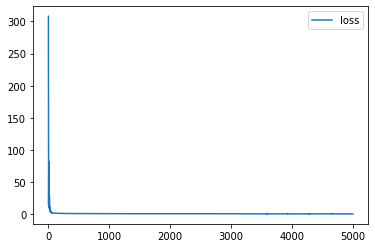

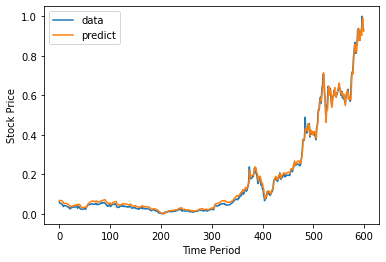

In [12]:
# Tesla High

tf.reset_default_graph()
tf.set_random_seed(0) 

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 20
data_dim = 24
hidden_dim = 34
output_dim = 1
learning_rate = 0.001
iterations = 5000

#data_btc = data_btc.to_numpy()

# train/test split
data_tsla = data_tsla.to_numpy()
train_size = int(len(data_tsla) * 0.7)
train_set = data_tsla[0:train_size]
test_set = data_tsla[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [1]]  # Next close price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)

        #print("[step: {}] loss: {}".format(i, step_loss))
    
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    plt.plot(loss_temp, label='loss')
    plt.legend()
    plt.show()

    # Plot predictions
    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.023060761392116547


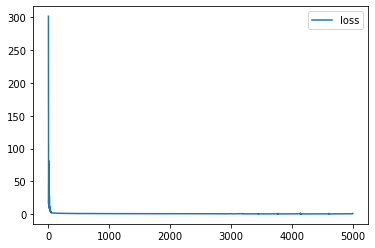

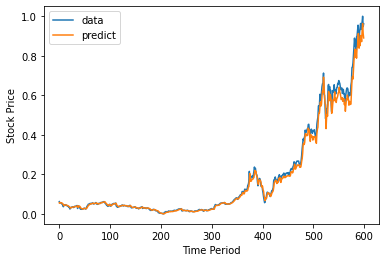

In [15]:
# Tesla Low

tf.reset_default_graph()
tf.set_random_seed(0) 

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 20
data_dim = 24
hidden_dim = 34
output_dim = 1
learning_rate = 0.001
iterations = 5000

#data_btc = data_btc.to_numpy()

# train/test split
#data_tsla = data_tsla.to_numpy()
train_size = int(len(data_tsla) * 0.7)
train_set = data_tsla[0:train_size]
test_set = data_tsla[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [2]]  # Next low price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)

        #print("[step: {}] loss: {}".format(i, step_loss))
    
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    plt.plot(loss_temp, label='loss')
    plt.legend()
    plt.show()

    # Plot predictions
    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

RMSE: 0.014073118567466736


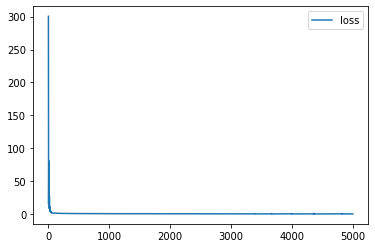

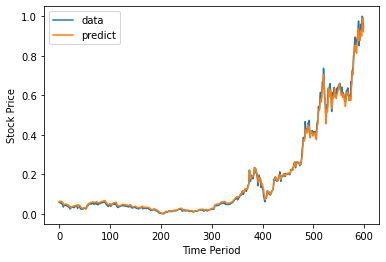

In [16]:
# Tesla Open

tf.reset_default_graph()
tf.set_random_seed(0) 

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 20
data_dim = 24
hidden_dim = 34
output_dim = 1
learning_rate = 0.001
iterations = 5000

#data_btc = data_btc.to_numpy()

# train/test split
#data_tsla = data_tsla.to_numpy()
train_size = int(len(data_tsla) * 0.7)
train_set = data_tsla[0:train_size]
test_set = data_tsla[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [0]]  # Next open price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    loss_temp = []
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        loss_temp.append(step_loss)

        #print("[step: {}] loss: {}".format(i, step_loss))
    
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    plt.plot(loss_temp, label='loss')
    plt.legend()
    plt.show()

    # Plot predictions
    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()